**Project 1**  
Miguel Venero Yupanqui  
CAP4453  
November 6, 2022  

**Manual Mode**

In [ ]:
# import needed libraries
import imageio as iio
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def warpImage(img,H,limit_coordinates):
  '''
  warps an image according to a homography H
  '''
  xmin = limit_coordinates[0]
  xmax = limit_coordinates[1]
  ymin = limit_coordinates[2]
  ymax = limit_coordinates[3]

  # the values that can take y
  i = np.linspace(0, img.shape[0]-1, img.shape[0]).astype(int)
  # the values that can take x
  j = np.linspace(0, img.shape[1]-1, img.shape[1]).astype(int)
  # combination of values that can take x, and y in a grid
  yv, xv = np.meshgrid(i, j)

  # number of points on the grid
  numpoints = xv.ravel().shape[0]

  # extract the color channels
  r = img[yv.ravel(),xv.ravel(),0]
  g = img[yv.ravel(),xv.ravel(),1]
  b = img[yv.ravel(),xv.ravel(),2]

  # all the values of x coordinates as a row
  x_cord = xv.ravel().reshape((1,numpoints))
  # all the values of y coordinates as a row
  y_cord = yv.ravel().reshape((1,numpoints))

  # define the homogeneous coordinates
  grid = np.concatenate((x_cord, y_cord, np.ones((1,numpoints))),axis=0)

  # transform the grid (your canvas) in the new coordinated determined by the homography defined below
  newgrid = np.matmul(H,grid)

  # Convert from homogeneous to heterogeneous coordinates
  newgridHetero = newgrid[:2,:]   # the x, and y

  thethirdcoordinate = newgrid[2,:]
  newgridHetero[0,:]= newgridHetero[0,:] / thethirdcoordinate
  newgridHetero[1,:]= newgridHetero[1,:] / thethirdcoordinate

  # define your new empty canvas (it will have -1 if is not defined)
  warped = -np.ones((ymax+1,xmax+1,3)).astype(np.int16)

  # Raw approximation. Considering just the integer values 
  newgrid2= newgridHetero.round().astype(np.int64)

  # only consider points that are in your area of interest (0 to 1000)
  validsX=np.bitwise_and(newgrid2[0,:]>=xmin,newgrid2[0,:]<xmax)
  validsY=np.bitwise_and(newgrid2[1,:]>=ymin,newgrid2[1,:]<ymax)
  valids = np.bitwise_and(validsX,validsY)

  # assign color to the pixels that are valids
  warped[newgrid2[1,valids],newgrid2[0,valids],0]=r[valids]
  warped[newgrid2[1,valids],newgrid2[0,valids],1]=g[valids]
  warped[newgrid2[1,valids],newgrid2[0,valids],2]=b[valids]

  # nearest Neighbor interpolation
  # your new canvas
  warped2 = np.zeros((ymax+1,xmax+1,3)).astype(np.uint8)
  # Area where we look for closest valid assignation
  area2check=5

  # loop over the valid area of the warped image
  for i in range(area2check,warped.shape[0]-area2check):
      for j in range(area2check,warped.shape[1]-area2check):
          # check if the pixel has a valid warped value        
          if warped[i,j,0]==-1:  #need to look for neighbor
              distance = area2check*area2check+1  # assign a distance larger than any that can be found in the area to check
              
              # loop over all the possible neighbors
              for k in range(i-area2check,i+area2check):
                  for l in range(j-area2check,j+area2check):
                      distancetested = (abs(k-i)+abs(l-j))  # L1 distance
                      if warped[k,l,0]>=0 and distancetested<distance:    # found a warped point , and it is closest
                          distance=distancetested
                          warped2[i,j]=warped[k,l]
          else:  #assign the valid warping
              warped2[i,j] =warped[i,j]

  return warped2

In [ ]:
def computeH(src_pts, dest_pts):
  '''
  calculates the homography between 2 sets of points
  '''
  vectors = []
  x = np.array([])

  # Make A matrix
  for p1, p2 in zip(src_pts, dest_pts):
    x = p1[0]; y = p1[1]; _x = p2[0]; _y = p2[1]
    vectors.append(np.array([-x, -y, -1, 0, 0, 0, _x * x, _x * y, _x]))
    vectors.append(np.array([0, 0, 0, -x, -y, -1, _y * x, _y * y, _y]))

  A = np.array(vectors)

  # compute SVD
  u, s, vh = np.linalg.svd(A, full_matrices=True)

  # get H from vh and divide by H[2,2]
  L = vh[-1,:] / vh[-1,-1]
  H_computed = L.reshape(3, 3)

  return H_computed

In [ ]:
def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length l and a sigma of sig
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
    return kernel / np.sum(kernel) 

In [ ]:
def l2(pt1, pt2):
  '''
  returns the distance between 2 points
  '''
  return np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)

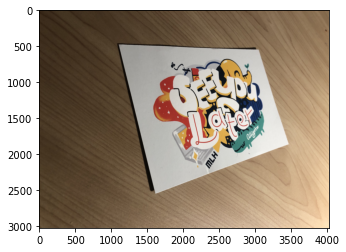

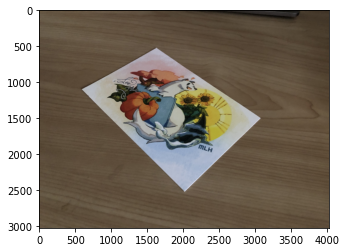

In [ ]:
# TODO: use 2 new picture and provide new points
img1 = iio.imread('https://github.com/MVeneroY/CAP4453/blob/main/project1/IMG_5189.JPG?raw=true')
img2 = iio.imread('https://github.com/MVeneroY/CAP4453/blob/main/project1/IMG_5188.JPG?raw=true')

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

# h and w are the dimensions
h = 400
w = 550

h2 = 400
w2 = 550

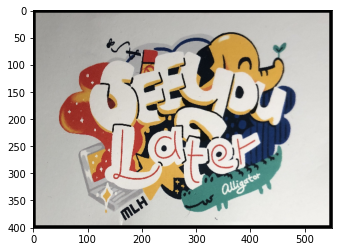

In [ ]:
# You may use the points provided below
src_points1 = np.float32([[1110,478], [1618,2547], [3470,1860], [3052,551]])
dest_points1 = np.float32([[0,0], [0,h], [w,h], [w,0]])

# Or try with your own set of points
# where the points go in the following order: top left, bottom left, bottom right, top right
# src_points1 = np.floar32([x1,y1],[x2,y2],[x3,y3],[x4,y4])

# Compute homography and warp image with it
H = computeH(src_points1, dest_points1)
warped = warpImage(img1, H, (0,w,0,h))
plt.imshow(warped)
plt.show()

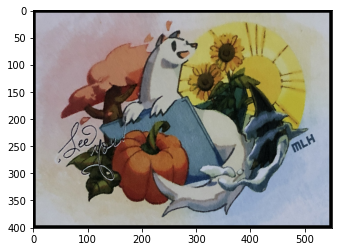

In [ ]:
src2 = np.float32([[1632,526],[594,1101],[2023,2518],[3083,1499]])
dest2 = np.float32([[0,0], [0,h2], [w2,h2], [w2,0]])

# try with your own set of points
# where the points go in the following order: top left, bottom left, bottom right, top right
# src_points1 = np.floar32([x1,y1],[x2,y2],[x3,y3],[x4,y4])

H2 = computeH(src2, dest2)
warped2 = warpImage(img2, H2, (0,w2,0,h2))
plt.imshow(warped2)
plt.show()

**Fully Automated Document Recovery**

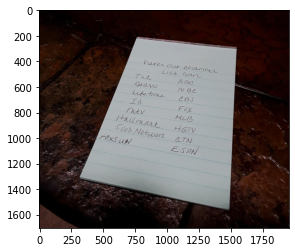

In [ ]:
# import opencv
import cv2 as cv

img3 = iio.imread('https://i.redd.it/bebi64i3kbb31.jpg')
plt.imshow(img3)
plt.show()

# write down dimensions of the final frame
h3 = 1200; w3 = 800
dest_points = np.array([[0,0], [0,h3], [w3,h3], [w3,0]])

In [ ]:
gk = gkern(9, 1.7)

# convert image to grayscale and use binarization after smoothing
bin = img3.copy()
bin = cv.cvtColor(bin, cv.COLOR_BGR2GRAY)
bin = cv.filter2D(src=bin, ddepth=-1, kernel=gk) 
bin.astype(np.uint8)
bin[bin<128] = 0
bin[bin>=128] = 255

# make areas uniform by removing small 'islands'
scale = 20
for i in range(scale,len(bin)-scale):
  for j in range(scale,len(bin[i])-scale):
    if bin[i][j] == 255 and bin[i+scale][j] == 0 and bin[i-scale][j] == 0:
      bin[i][j] = 0
    if bin[i][j] == 0 and ((bin[i+scale][j] == 255 and bin[i-scale][j] == 255) or (bin[i][j+scale] == 255 and bin[i][j-scale] == 255)):
      bin[i][j] = 255

# use canny to get edges from bin
canny = cv.Canny(image=bin, threshold1=150, threshold2=170)

# use Harris to get corners and set their values to 128
corners = cv.cornerHarris(canny, 2, 5, 0.07)
dest = cv.dilate(corners, None)
bin[corners > 0.01 * dest.max()] = 128

# append all detected corners to a list
corner_list = []
for i in range(len(bin)):
  for j in range(len(bin[i])):
    if bin[i][j] == 128:
      corner_list.append([i,j])
corner_list = np.array(corner_list).astype(np.float32)

topleft = [0,0]
topright = [0,len(bin[0])]
botleft = [len(bin),0]
botright = [len(bin),len(bin[0])]

tl = topleft
tr = topright
bl = botleft
br = botright

tlmin = corner_list[0]; trmin = corner_list[0]; blmin = corner_list[0]; brmin = corner_list[0] 

# get corners closest to the 4 vertices in the image window
for i in range(len(corner_list)):
  if l2(corner_list[i],topleft) < l2(tlmin,topleft):
    tlmin = corner_list[i]
    tl = corner_list[i]
  if l2(corner_list[i],topright) < l2(trmin,topright):
    trmin = corner_list[i]
    tr = corner_list[i]
  if l2(corner_list[i],botleft) < l2(blmin,botleft):
    blmin = corner_list[i]
    bl = corner_list[i]
  if l2(corner_list[i],botright) < l2(brmin,botright):
    brmin = corner_list[i]
    br = corner_list[i]

# Store coordinate pairs as [x,y]
detected_corners = np.array([[tl[1],tl[0]],[bl[1],bl[0]],[br[1],br[0]],[tr[1],tr[0]]])

In [ ]:
# get homography
H3 = computeH(detected_corners,dest_points)

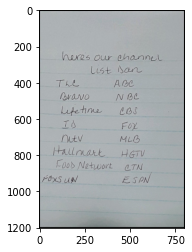

In [ ]:
# warp image
warped3 = warpImage(img3, H3, (0,w3,0,h3))
plt.imshow(warped3)
plt.show()